# TensorFlow 2.0 Question Answering
### Identify the answers to real user questions about Wikipedia page content

   This is a question an open-domain question answering (QA) system should be able to respond to. QA systems emulate how people look for information by reading the web to return answers to common questions. Machine learning can be used to improve the accuracy of these answers.

Existing natural language models have been focused on extracting answers from a short paragraph rather than reading an entire page of content for proper context. As a result, the responses can be complicated or lengthy. A good answer will be both succinct and relevant.

In this competition, your goal is to predict short and long answer responses to real questions about Wikipedia articles. The dataset is provided by Google's Natural Questions, but contains its own unique private test set. A visualization of examples shows long and—where available—short answers. In addition to prizes for the top teams, there is a special set of awards for using TensorFlow 2.0 APIs.

**What am I predicting?**<br>
For each article + question pair, you must predict / select long and short form answers to the question drawn directly from the article. - A long answer would be a longer section of text that answers the question - several sentences or a paragraph. - A short answer might be a sentence or phrase, or even in some cases a YES/NO. The short answers are always contained within / a subset of one of the plausible long answers. - A given article can (and very often will) allow for both long and short answers, depending on the question.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cloudpoint3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
pd.set_option('max_columns', 1000)
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import plotly.figure_factory as ff
import gc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import json
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import numpy as np

## Reading the data

### Reading the Train Data

In [5]:
def read_data(path, sample = True, chunksize = 50000):
    if sample == True:
        df = []
        with open(path, 'rt') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Our sampled dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Our dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train = read_data('simplified-nq-train.jsonl', sample = True)
train.head()

Our sampled dataset have 50000 rows and 6 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [ ]:
train[1:2]['question_text']

1    how i.met your mother who is the mother
Name: question_text, dtype: object

### Reading the Test Data

In [ ]:
test.head()

,example_id,question_text,document_text,long_answer_candidates
0,-1220107454853145600,who is the south african high commissioner in ...,"High Commission of South Africa , London - wik...","[{'end_token': 136, 'start_token': 18, 'top_le..."
1,8777415633185303552,the office episode when they sing to michael,Michael 's Last Dundies - wikipedia <H1> Micha...,"[{'end_token': 190, 'start_token': 23, 'top_le..."
2,4640548859154538496,what is the main idea of the cross of gold speech,Cross of gold speech - wikipedia <H1> Cross of...,"[{'end_token': 165, 'start_token': 12, 'top_le..."
3,-5316095317154496512,when was i want to sing in opera written,Wilkie Bard - wikipedia <H1> Wilkie Bard </H1>...,"[{'end_token': 105, 'start_token': 8, 'top_lev..."
4,-8752372642178983936,who does the voices in ice age collision course,Ice Age : Collision Course - Wikipedia <H1> Ic...,"[{'end_token': 287, 'start_token': 16, 'top_le..."


## The shape of the data

In [ ]:
print(train.shape)
print(test.shape)

(50000, 6)
(346, 4)


**In the train data, we have 50000 rows and 6 columns. In the test data we 346 rows and 4 columns.**

## Just checking if there are any null values in all the features

In [ ]:
def missing_values(data):
    for i in data.columns.values:
        k=data[i].isnull().sum()
        print(k) 
    print(sep='')
    
    
print("Null values in all features of train data")    
missing_values(train)
print("Null values in all features of test data")    
missing_values(test)

Null values in all features of train data
0
0
0
0
0
0

Null values in all features of test data
0
0
0
0



**We can see that there are no null values in any of the features of the data.We can easily move forward with the data without making changes in them.** 

In [ ]:
train['long_answer_candidates'].head()

0    [{'start_token': 14, 'top_level': True, 'end_t...
1    [{'start_token': 28, 'top_level': True, 'end_t...
2    [{'start_token': 14, 'top_level': True, 'end_t...
3    [{'start_token': 28, 'top_level': True, 'end_t...
4    [{'start_token': 32, 'top_level': True, 'end_t...
Name: long_answer_candidates, dtype: object

In [ ]:
train.loc[47779,'annotations']

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 459, 'candidate_index': 44, 'end_token': 541},
  'short_answers': [{'start_token': 511, 'end_token': 519}],
  'annotation_id': 15797189430231657973}]

In [ ]:
train.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [ ]:
test.head()

,example_id,question_text,document_text,long_answer_candidates
0,-1220107454853145600,who is the south african high commissioner in ...,"High Commission of South Africa , London - wik...","[{'end_token': 136, 'start_token': 18, 'top_le..."
1,8777415633185303552,the office episode when they sing to michael,Michael 's Last Dundies - wikipedia <H1> Micha...,"[{'end_token': 190, 'start_token': 23, 'top_le..."
2,4640548859154538496,what is the main idea of the cross of gold speech,Cross of gold speech - wikipedia <H1> Cross of...,"[{'end_token': 165, 'start_token': 12, 'top_le..."
3,-5316095317154496512,when was i want to sing in opera written,Wilkie Bard - wikipedia <H1> Wilkie Bard </H1>...,"[{'end_token': 105, 'start_token': 8, 'top_lev..."
4,-8752372642178983936,who does the voices in ice age collision course,Ice Age : Collision Course - Wikipedia <H1> Ic...,"[{'end_token': 287, 'start_token': 16, 'top_le..."


**We can see that the columns in the train data are "document_text,long_answer_candidates,question_text,annotations,document_url,example_id".
Similarly, we can see that the columns in the test data are "example_id,question_text,document_text,long_answer_candidates"**

**We can also see that, in the train data,"long answer questions","annotations" data is in the json format. To extract that format, we havt to use read_json() to store in a dataframe.**

In [ ]:
train.iloc[30].annotations[0]['short_answers'][0]['start_token']

214

In [ ]:
train.shape

(50000, 6)

In [ ]:
train['annotations'][49999][0]['short_answers'][0]['start_token']

244

## Checking for YES or NO answers

In [ ]:
none_list=[]
yes_list=[]
no_list=[]

for i in range(50000):
    if train['annotations'][i][0]['yes_no_answer'] =='NONE':
        none_list.append(i)
    elif train['annotations'][i][0]['yes_no_answer'] =='YES':
        yes_list.append(i)
    elif train['annotations'][i][0]['yes_no_answer'] =='NO':
        no_list.append(i)
        
print("The number of \"NONE\" results are",len(none_list))       
print("The number of \"YES\" results are",len(yes_list))
print("The number of \"NO\" results are",len(no_list))


The number of "NONE" results are 49380
The number of "YES" results are 376
The number of "NO" results are 244


**We can see, the division of NONE, YES and NO answers. We can see that the majority of the answers are having 'NONE' as the answer.**

In [ ]:
train['annotations'][i][0]['yes_no_answer']

'NONE'

In [ ]:
df=pd.DataFrame([[len(none_list),len(yes_list),len(no_list)]],columns=["NONE","YES","NO"])
df

,NONE,YES,NO
0,49380,376,244


### Barplot of the yes_no data

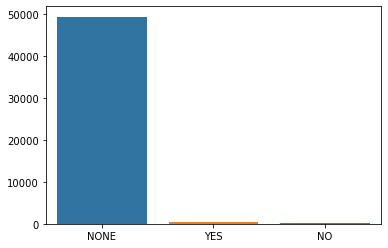

In [ ]:
sns.barplot(data=df)

In [ ]:
train.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [ ]:
train['annotations'][49999][0]

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': 229, 'candidate_index': 20, 'end_token': 307},
 'short_answers': [{'start_token': 244, 'end_token': 246}],
 'annotation_id': 6925218976648108404}

In [ ]:
train['annotations'][i][0]['short_answers'][0]['start_token']

244

### Checking for the empty Short and Long Answers (Not yet confirmed)

In [6]:
empty_shortans=[]
empty_longans=[]
for i in range(50000):
    if not train['annotations'][i][0]['short_answers']:
        empty_shortans.append(i)
    elif not train['annotations'][i][0]['long_answer']:
        empty_longans
print("Number of \"no short answers\": ",len(empty_shortans))
print("Number of \"no long answers\": ",len(empty_longans))

Number of "no short answers":  32402
Number of "no long answers":  0


**Number of no short answers is 32402 and there are no empty long answer fields i.e every question has long answer which is not empty (We will check in detail and confirm this in the below step).**

## Plot-Analysis of Short answer indices

In [7]:
shortans_startindices=[]
for i in range(50000):
    if i not in empty_shortans:
        c=train['annotations'][i][0]['short_answers'][0]['start_token']
        shortans_startindices.append(c)
print(len(shortans_startindices))   

17598


In [25]:
train['annotations'][49999][0]

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': 229, 'candidate_index': 20, 'end_token': 307},
 'short_answers': [{'start_token': 244, 'end_token': 246}],
 'annotation_id': 6925218976648108404}

## Univariate DisPlot of the Size of Short Answer Start indices

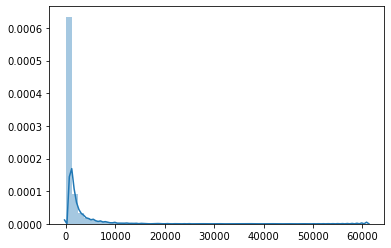

In [ ]:
sns.distplot(shortans_startindices)

## KDE of the Size of Short Answer start indices

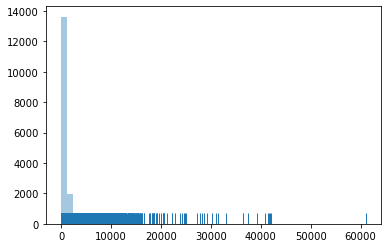

In [ ]:
sns.distplot(shortans_startindices,kde=False, rug=True)

## KDEof the Size of Short Answer End indices

In [ ]:
shortans_endindices=[]
for i in range(50000):
    if i not in empty_shortans:
        c=train['annotations'][i][0]['short_answers'][0]['end_token']
        shortans_endindices.append(c)
print(len(shortans_endindices))   

17598


## Univariate DisPlot of the Size of Short Answer end indices

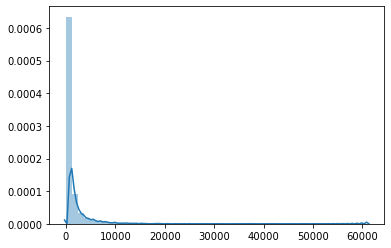

In [ ]:
sns.distplot(shortans_endindices)

## KDE of the Size of Short Answer end indices

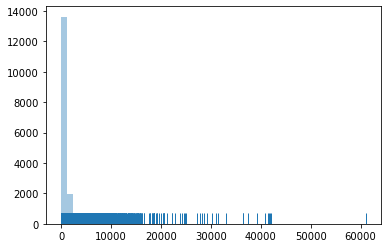

In [ ]:
sns.distplot(shortans_endindices,kde=False, rug=True)

### Finding the difference of Short Answer start and end indices

In [ ]:
diff=np.array(shortans_startindices)-np.array(shortans_endindices)
diff

array([-9, -2, -2, ..., -2, -1, -2])

## Plotting the above Differece 

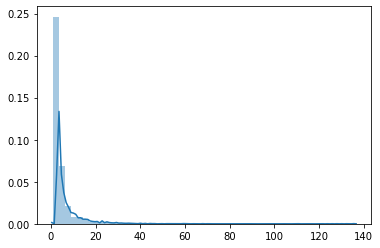

In [ ]:
sns.distplot(abs(diff))

## KDE of the Difference

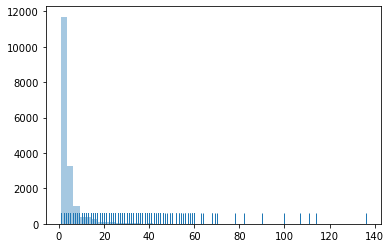

In [ ]:
sns.distplot(abs(diff),kde=False,rug=True)

In [ ]:
train['annotations'][499][0]

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': -1, 'candidate_index': -1, 'end_token': -1},
 'short_answers': [],
 'annotation_id': 16310544866491807081}

In [ ]:
train['annotations'][4999][0]

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': 287, 'candidate_index': 18, 'end_token': 334},
 'short_answers': [{'start_token': 301, 'end_token': 311}],
 'annotation_id': 17886844759637082436}

In [ ]:
train['annotations'][4999][0]['long_answer']['end_token']

334

# Analysis of Long Answer indices

## Finding the empty Long answer indices

In [ ]:
nonelong=[]
for i in range(50000):
    if (train['annotations'][i][0]['long_answer']['start_token'] and 
        train['annotations'][i][0]['long_answer']['end_token'])==-1:
        nonelong.append(i)
print(len(nonelong))        

25163


In [ ]:
train['annotations'][4][0]['long_answer']['start_token'] 

-1

In [ ]:
longans=[]
for i in range(50000):
    if i not in nonelong:
        longans.append(i)

In [ ]:
longans_startindices=[]
for i in longans:
    c=train['annotations'][i][0]['long_answer']['start_token']
    longans_startindices.append(c)
print(len(longans_startindices))

24837


## Univariate DisPlot of the Size of Long Answer Start indices

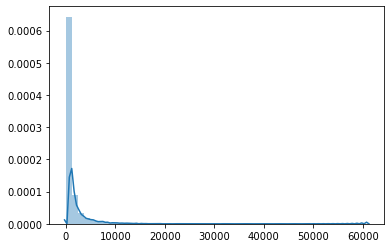

In [ ]:
sns.distplot(longans_startindices)

## KDE DisPlot of the Size of Long Answer Start indices

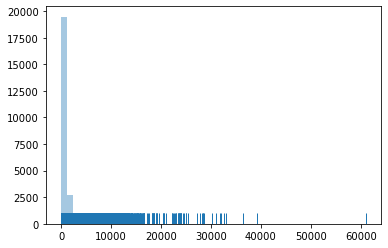

In [ ]:
sns.distplot(longans_startindices,kde=False,rug=True)

## Plot of long answer End indices

In [ ]:
longans_endindices=[]
for i in longans:
    c=train['annotations'][i][0]['long_answer']['end_token']
    longans_endindices.append(c)
print(len(longans_endindices))

24837


## Univariate DisPlot of the Long Answer end indices

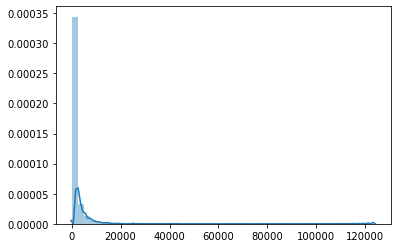

In [ ]:
sns.distplot(longans_endindices)

## KDEof the Size of Long Answer End indices

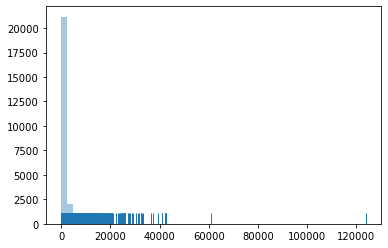

In [ ]:
sns.distplot(longans_endindices,kde=False,rug=True)

## Difference in the Long Start and End indices

In [ ]:
diff1=abs(np.array(longans_startindices)-np.array(longans_endindices))
diff1

array([ 67,  98, 119, ...,  67, 148,  78])

## Univariate DisPlot of the Size of Difference indices

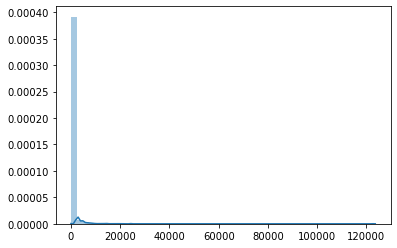

In [ ]:
sns.distplot(diff1)

## KDE of the Difference indices

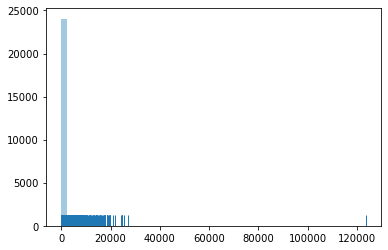

In [ ]:
sns.distplot(diff1,kde=False,rug=True)

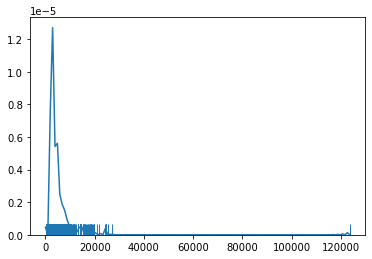

In [ ]:
sns.distplot(diff1,hist=False,rug=True)

In [ ]:
train['annotations'][4999][0]

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': 287, 'candidate_index': 18, 'end_token': 334},
 'short_answers': [{'start_token': 301, 'end_token': 311}],
 'annotation_id': 17886844759637082436}

## Range of values

In [ ]:
ci=[]
for i in range(50000):
    c=train['annotations'][i][0]['long_answer']['candidate_index']
    ci.append(c)


### Min and Max

In [ ]:
min(ci)

-1

In [ ]:
max(ci)

1959

In [ ]:
train['long_answer_candidates'][80][0]['start_token']

24

### Long answer candidates analysis

## Start token

In [ ]:
longanscanst=[]
for i in range(50000):
    c1=train['long_answer_candidates'][i][0]['start_token']
    longanscanst.append(c1)


## End token

In [ ]:
longanscanen=[]
for i in range(50000):
    c1=train['long_answer_candidates'][i][0]['end_token']
    longanscanen.append(c1)

## Univariate DisPlot of the Size of Candidate long Answer start indices

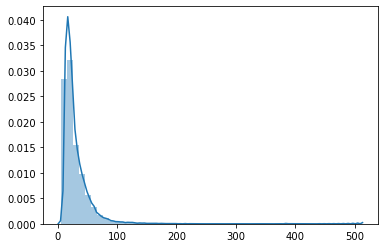

In [ ]:
sns.distplot(longanscanst)

## KDE of the Size of Candidate long Answer start indices

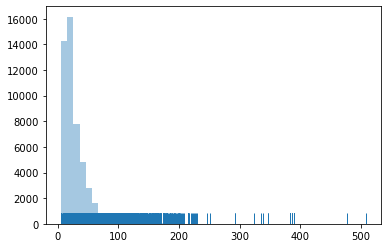

In [ ]:
sns.distplot(longanscanst,kde=False,rug=True)

## Univariate DisPlot of the Size of Candidate long Answer end indices

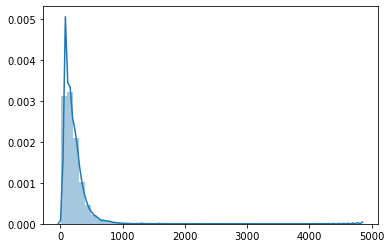

In [ ]:
sns.distplot(longanscanen)

## KDE of the Size of Candidate long Answer end indices

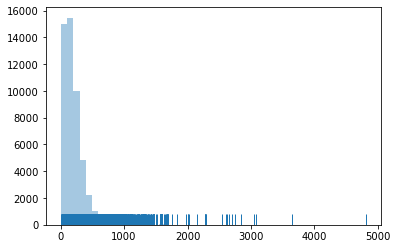

In [ ]:
sns.distplot(longanscanen,kde=False,rug=True)

## Difference

In [ ]:
diff2=np.array(longanscanst)-np.array(longanscanen)
diff2=np.array(diff2)

## Univariate DisPlot of the Size of Candidate difference Answer indices

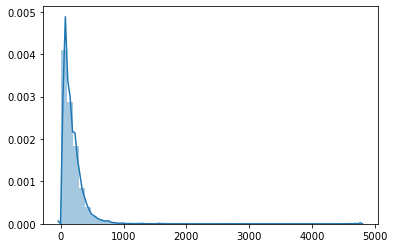

In [ ]:
sns.distplot(abs(diff2))

## KDE of the Size of Candidate long Answer difference  indices

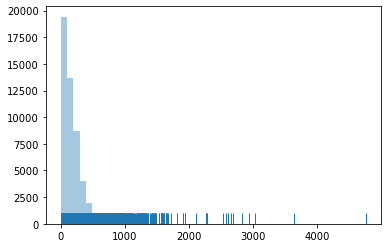

In [ ]:
sns.distplot(abs(diff2),kde=False,rug=True)

In [ ]:
train.columns

Index(['document_text', 'long_answer_candidates', 'question_text',
       'annotations', 'document_url', 'example_id'],
      dtype='object')

In [ ]:
train.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [ ]:
train["annotations"][0]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 1952,
   'candidate_index': 54,
   'end_token': 2019},
  'short_answers': [{'start_token': 1960, 'end_token': 1969}],
  'annotation_id': 593165450220027640}]

## Word frequency in question_text

In [ ]:
series=train['question_text']
top=0
bot=20
cv = CountVectorizer()   
cv_fit = cv.fit_transform(series)    
word_list = cv.get_feature_names(); 
count_list = cv_fit.toarray().sum(axis=0)
frequency = pd.DataFrame({'Word': word_list, 'Frequency': count_list})
frequency.sort_values(['Frequency'], ascending = False, inplace = True)
frequency['Percentage'] = frequency['Frequency']/frequency['Frequency'].sum()
frequency.drop('Frequency', inplace = True, axis = 1)
frequency['Percentage'] = frequency['Percentage'].round(3)
frequency = frequency.iloc[top:bot]  
#frequency.set_index('Word', inplace = True) 
#plt.bar(frequency['Word'],pd.Series(height=frequency['Percentage']))
frequency

,Word,Percentage
23081,the,0.095
16422,of,0.043
11623,in,0.038
25046,who,0.030
12135,is,0.025
24998,what,0.019
25010,when,0.016
23351,to,0.013
1518,and,0.012
25012,where,0.012


In [ ]:
frequency.columns

Index(['Word', 'Percentage'], dtype='object')

## Bar plot of words

<BarContainer object of 20 artists>

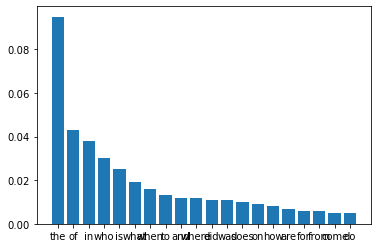

In [ ]:
plt.bar(frequency['Word'],height=pd.Series(frequency['Percentage']),width=0.8)

## TFIDF of the words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(series)

<50000x25631 sparse matrix of type '<class 'numpy.float64'>'
	with 431278 stored elements in Compressed Sparse Row format>

In [ ]:
word_list = vectorizer.get_feature_names()

In [ ]:
words2=[]
idf2=vectorizer.idf_
features=np.argsort(idf2)[::-1]
for i in features[0:30]:
    words2.append(word_list[i])
print(words2)

['δg', 'indexes', 'indemnity', 'indecent', 'indaver', 'ind', 'incus', 'incurred', 'incumbent', 'incubus', 'incremented', 'increasingly', 'incorrect', 'incorporation', 'incorporate', 'inconvenient', 'inconvenience', 'inconoscope', 'incomplete', 'incompetent', 'incoming', 'incomes', 'inclined', 'incisions', 'incidence', 'inchon', 'incarnations', 'incarnation', 'incarnate', 'inazo']


In [ ]:
all_features2=vectorizer.get_feature_names()
words2=[]
idf2=vectorizer.idf_
features=np.argsort(idf2)[::-1]
for i in features[0:60]:
    words2.append(all_features2[i])
print(words2)


['δg', 'indexes', 'indemnity', 'indecent', 'indaver', 'ind', 'incus', 'incurred', 'incumbent', 'incubus', 'incremented', 'increasingly', 'incorrect', 'incorporation', 'incorporate', 'inconvenient', 'inconvenience', 'inconoscope', 'incomplete', 'incompetent', 'incoming', 'incomes', 'inclined', 'incisions', 'incidence', 'inchon', 'incarnations', 'incarnation', 'incarnate', 'inazo', 'inauguration', 'independently', 'indianism', 'inflame', 'indication', 'infinitives', 'infiltration', 'infiltrated', 'infian', 'infestans', 'inferno', 'infective', 'infections', 'infants', 'inerrancy', 'inequalities', 'inelastic', 'industrialisation', 'indusind', 'inductors', 'inductive', 'induced', 'induce', 'indopak', 'indoor', 'individualism', 'indispensable', 'indigestible', 'indigent', 'indigenously']


## Word Cloud

In [ ]:
from wordcloud import WordCloud

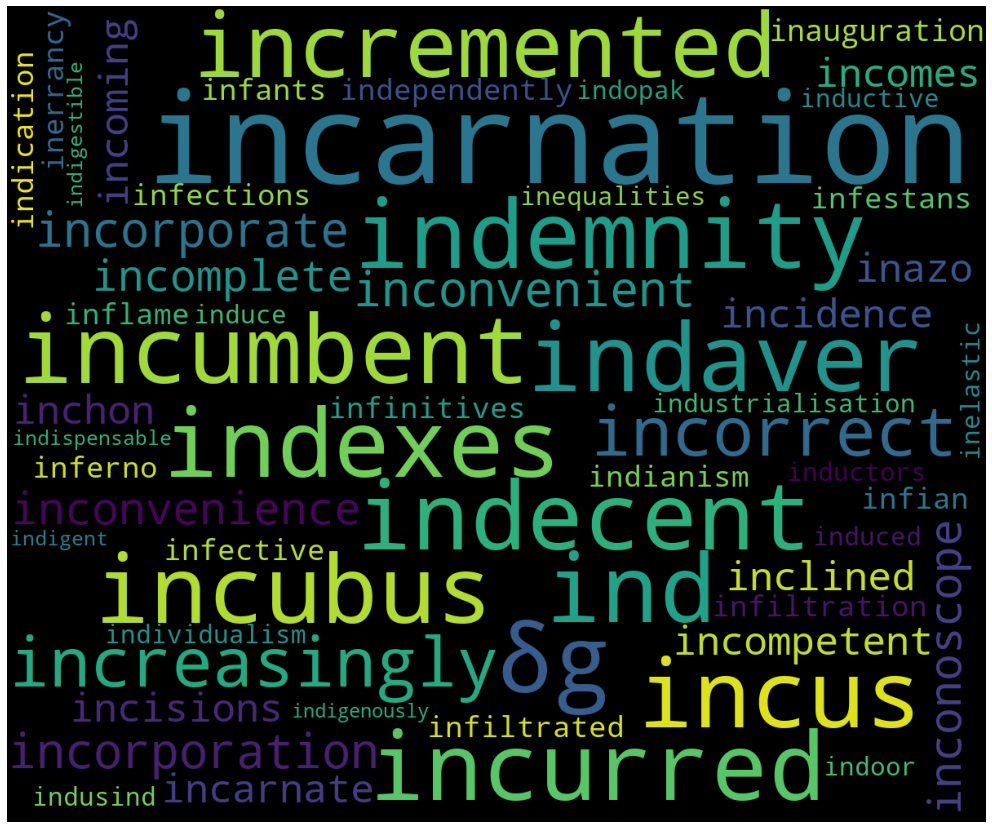

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1200, height = 1000).generate(" ".join(words2))
plt.figure(figsize = (20, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()